Curso práctico de Deep Learning aplicado a Metrología Cuántica:
1) Introducción al Deep Learning: problema de fashion MNIST
2) Explicación física del problema de Quantum Parameter Estimation 
3) Aplicación de Deep Learning al problema

Curso hecho por Manuel Eduardo González Lastre

Importamos tensorflow, keras y el dataset de fashion MNIST, con artículos de ropa que trataremos de clasificar

In [19]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from numpy import savetxt
from scipy.sparse.linalg import expm, expm_multiply
from scipy import sparse
import matplotlib.pyplot as plt
fashion_mnist=keras.datasets.fashion_mnist
(X_train_full,y_train_full),(X_test,y_test)=fashion_mnist.load_data()

Vamos a preprocesar las imágenes para que los valores de los pixeles vayan de 0 a 1

In [20]:
X_valid , X_train = X_train_full[:5000]/255.0 , X_train_full[5000:]/255.0
y_valid , y_train = y_train_full[:5000] , y_train_full[5000:]
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress",
             "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Anckle Boot"]

<function matplotlib.pyplot.show(close=None, block=None)>

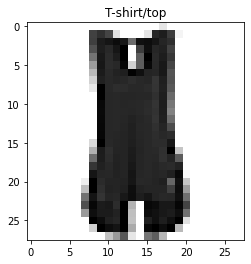

In [24]:
loc=4
plt.imshow(X_valid[loc,:,:], cmap = plt.cm.binary)
plt.title(class_names[y_valid[loc]])
plt.show

Construimos un perceptron multicapa utilizando la API Sequential de Keras

In [25]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Ahora que hemos construido el modelo solo nos queda compilarlo, indicando los hiperparámetros, 
la función de pérdida a minimizar y el optimizador

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

history=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid), 
                  batch_size = 64, verbose = 1)

Epoch 1/30
860/860 [==============================] - 10s 11ms/step - loss: 0.4982 - accuracy: 0.8210 - val_loss: 0.3950 - val_accuracy: 0.8566
Epoch 2/30
860/860 [==============================] - 11s 12ms/step - loss: 0.3651 - accuracy: 0.8663 - val_loss: 0.3684 - val_accuracy: 0.8668
Epoch 3/30
860/860 [==============================] - 9s 11ms/step - loss: 0.3273 - accuracy: 0.8786 - val_loss: 0.3344 - val_accuracy: 0.8778
Epoch 4/30
860/860 [==============================] - 9s 11ms/step - loss: 0.3026 - accuracy: 0.8874 - val_loss: 0.3062 - val_accuracy: 0.8900
Epoch 5/30
860/860 [==============================] - 9s 11ms/step - loss: 0.2864 - accuracy: 0.8941 - val_loss: 0.3096 - val_accuracy: 0.8890
Epoch 6/30
860/860 [==============================] - 10s 11ms/step - loss: 0.2702 - accuracy: 0.8998 - val_loss: 0.3287 - val_accuracy: 0.8804
Epoch 7/30
860/860 [==============================] - 9s 10ms/step - loss: 0.2581 - accuracy: 0.9029 - val_loss: 0.3067 - val_accuracy: 0.8

<AxesSubplot:>

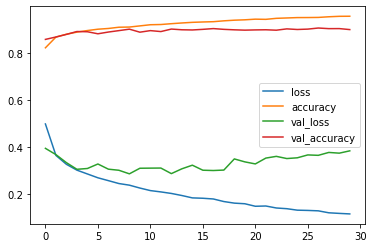

In [27]:
pd.DataFrame(history.history).plot()

Vemos que el modelo tiene una buena precisión en el set de validación y además no se ha visto overfitting en el entrenamiento.

Sin embargo, también vemos que ha mejorado muy poco a lo largo de las ultimas iteraciones.
¿Existe alguna manera de parar el entrenamiento cuando empezamos a mejorar muy lentamente?

In [28]:
from keras.callbacks import EarlyStopping

es = EarlyStopping( monitor = "val_accuracy", 
                   min_delta = 0.1, patience = 5, restore_best_weights=True)

model_es=keras.models.Sequential()
model_es.add(keras.layers.Flatten(input_shape=[28,28]))
model_es.add(keras.layers.Dense(300,activation="relu"))
model_es.add(keras.layers.Dense(100,activation="relu"))
model_es.add(keras.layers.Dense(10,activation="softmax"))
model_es.summary()
model_es.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",metrics=["accuracy"])

history=model_es.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid), 
                     batch_size = 64, verbose = 1, callbacks = [es])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
860/860 [==============================] - 9s 11ms/step - loss: 0.4944 - accuracy: 0.8239 - val_loss: 0.3935 - val_accuracy: 0.8556
Epoch 2/30
860/860 [==============================] - 9s 10ms/step - loss: 0.3659 - accuracy: 0.8658 - 

<AxesSubplot:>

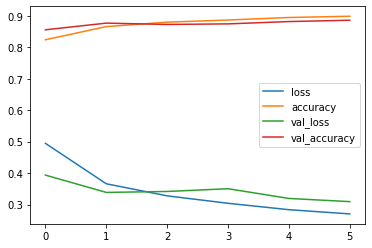

In [31]:
pd.DataFrame(history.history).plot()

Ahora vamos a introducir nuestro problema de Quantum Parameter Estimation.
Tenemos un átomo con un cierto momento dipolar D, irradiado por un láser con amplitud
de campo eléctrico E_0. El láser puede contar con un cierto detunning, delta, que es
la diferencia entre la frecuencia del láser y la de resonancia del átomo.

El átomo se modeliza como un TLS y puede decaer a su estado fundamental emitiendo fotones

En este tipo de problemas, dada la naturaleza estocástica del proceso, 
se da lo que se llama "unraveling de trayectorias", que significa que
puedes tener trayectorias muy distintas incluso aunque generes las trayectorias
con los mismos parámetros dinámicos

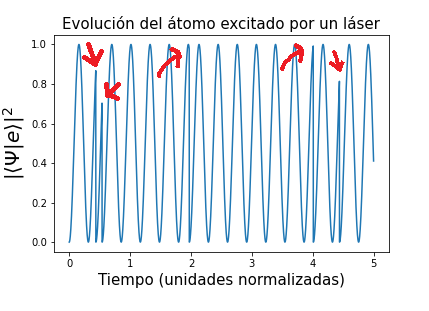

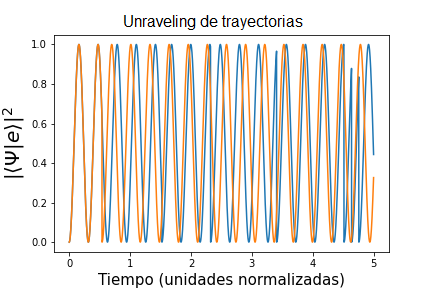

Nosotros queremos resolver el problema de Quantum Parameter Estimation, mediante el cuál
utilizamos los tiempos de emisión de fotones ()

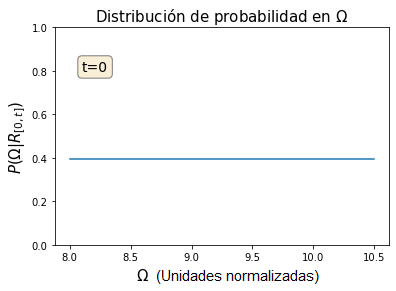
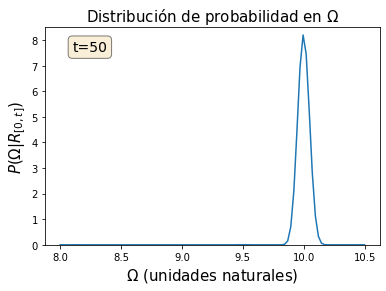

In [38]:
n_Delta=100 # Número de frecuencias que hemos simulado, será el número de clases
# en los que hagamos la clasificación
Delta_vec=np.linspace(1,5,n_Delta)

Delta_class=list(range(n_Delta))


diccionario_clases=dict(zip(Delta_vec,Delta_class))
#print(diccionario_clases)

# Lo que hemos hecho es pasar de valores numericos de frecuencia a clases
# que son 0,1,2,3... que son las que el clasificador entiende como categorías



#Abrimos el csv y sacamos la información necesaria
out_name="clicks_deltas_Omega_3.csv"

#out_name nos dice la ubicación del archivo, contiene los clicks
#Para abrirlo y leerlo
Deltas_and_clicks=loadtxt(out_name,delimiter=",")
# Esta matriz contiene en su primera columna las frecuencias Omega
# y en todo lo demás el registro de fotodetección asociado

y_full=Deltas_and_clicks[:,0] # las frecuencias
y_full_class=np.vectorize(diccionario_clases.get)(y_full)
X_full=Deltas_and_clicks[:,1:] # los tiempos de emisión

# Reescalamos los pixels
maxX=np.amax(X_full)
# Podemos separar en splits de training y test con la función de sklearn
# pero realmente yo ya he puesto los clicks en el txt tal que se podríamos 
# simplemente asignar un corte y ya está
ratio=0.8
limit=int(ratio*len(y_full))
y_train,y_valid=y_full_class[:limit],y_full_class[limit:]
X_train,X_valid=X_full[:limit,:]/maxX,X_full[limit:,:]/maxX
print(y_valid[0:4]) # Comprobamos que el diccionario haya creado traducido bien los vectores y


[0 1 2 3]


In [30]:
model_adam_Omega_3=keras.models.Sequential([
   # keras.layers.Dense(10,activation="relu",input_shape=X_train.shape[1:]),
    # El .shape[1:] es porque el primer indice nos dice el numero de tensores
    # que disponemos de datos y cada tensor es lo que le llega realmente a la
    # red como input. Por eso, determinamos el input de la primera capa así
    keras.layers.Dense(300,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(n_Delta,activation="softmax")
    
    # El activador es softmax para que salga una distribucion normalizada
    
    
    ])

model_adam_Omega_3.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",metrics=["accuracy"])
model_adam_Omega_3.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))


Epoch 1/20
2500/2500 [==============================] - 11s 4ms/step - loss: 3.9373 - accuracy: 0.0313 - val_loss: 3.8054 - val_accuracy: 0.0362
Epoch 2/20
2500/2500 [==============================] - 10s 4ms/step - loss: 3.8015 - accuracy: 0.0362 - val_loss: 3.7804 - val_accuracy: 0.0380
Epoch 3/20
2500/2500 [==============================] - 10s 4ms/step - loss: 3.7948 - accuracy: 0.0360 - val_loss: 3.7921 - val_accuracy: 0.0355
Epoch 4/20
2500/2500 [==============================] - 10s 4ms/step - loss: 3.7884 - accuracy: 0.0373 - val_loss: 3.7899 - val_accuracy: 0.0354
Epoch 5/20
2500/2500 [==============================] - 10s 4ms/step - loss: 3.7841 - accuracy: 0.0370 - val_loss: 3.7682 - val_accuracy: 0.0370
Epoch 6/20
2500/2500 [==============================] - 10s 4ms/step - loss: 3.7802 - accuracy: 0.0379 - val_loss: 3.7663 - val_accuracy: 0.0377
Epoch 7/20
2500/2500 [==============================] - 10s 4ms/step - loss: 3.7767 - accuracy: 0.0376 - val_loss: 3.8142 - val_ac

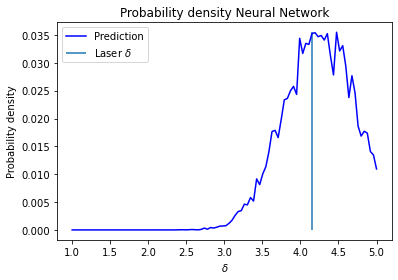

In [43]:
loc = 78
proba_nn = model_adam_Omega_3.predict(X_valid[loc:loc+1])

plt.plot(Delta_vec, proba_nn[0,:], "b-")
plt.title("Probability density Neural Network")
plt.xlabel(r"$\delta$")
plt.ylabel("Probability density")

plt.vlines(Delta_vec[y_valid[loc]], 0.0, np.amax(proba_nn))
plt.legend(["Prediction", "Laser $\delta$"])

In [ ]:
Serge Haroche